In [2]:
import os
import sys
import glob
from obspy.core import read, UTCDateTime
import matplotlib.pyplot as plt
from obspy.io.xseed import Parser
from obspy.geodetics import gps2dist_azimuth
from obspy.taup import TauPyModel
from scipy.signal import hilbert, chirp
import numpy as np
from scipy import signal

#define functions 

In [28]:
def raylei(st):
 
  st[0].detrend()
  st[1].detrend()
  st[2].detrend()
  st[0].normalize()
  st[1].normalize()
  st[2].normalize()
    
  st[0].data=st[0].data-np.mean(st[0].data)
  st[0].data=st[0].data/max(abs(st[0].data))
  st[1].data=st[1].data/max(abs(st[2].data))
  st[2].data=st[2].data/max(abs(st[2].data))


  tr1=st[0].filter('bandpass', freqmin=0.02, freqmax=0.2, corners=4, zerophase=True)
  tr2=st[1].filter('bandpass', freqmin=0.02, freqmax=0.2, corners=4, zerophase=True)
  tr3=st[2].filter('bandpass', freqmin=0.02, freqmax=0.2, corners=4, zerophase=True)
    
  st[0].data=st[0].data/max(abs(st[0].data))
  st[1].data=st[1].data/max(abs(st[1].data))
  st[2].data=st[2].data/max(abs(st[2].data))
  (dis,za,baz)=gps2dist_azimuth(st[0].stats.sac.evla, st[0].stats.sac.evlo,st[0].stats.sac.stla,st[0].stats.sac.stlo)
  end=dis/2500
  start=dis/5000
  np1=tr1.slice(tr1.stats.starttime+start,tr1.stats.starttime+end)
  np2=tr2.slice(tr2.stats.starttime+start,tr2.stats.starttime+end)
  np3=tr3.slice(tr2.stats.starttime+start,tr2.stats.starttime+end)
  np1.detrend()
  np2.detrend()
  np3.detrend()
  np1.normalize()
  np2.normalize()
  np3.normalize()
  print ('OK')
  evlos=[]
  crz=np.zeros(361)
  crz2=np.zeros(361)
  raz=(baz-180+360)%360
  for j in range(0,361):
      i=(raz-j+360)%360
      rad=np1.data*np.cos(i/180*np.pi)+np2.data*np.sin(i/180*np.pi)
      h= hilbert(rad)
      hr=np.imag(h)
      evlos.append(np.abs(h))    
      corrr = corr(hr, hr,)
      corzr = corr(hr, np3.data)
      corzz = corr(np3.data,np3.data)
      crz[j]=corzr/(corzz*corrr)**(0.5)
      crz2[j]=corzr/corzz
  return crz,crz2,evlos

def corr(l1,l2):
    l=l1*l2
    s=np.sum(l)
    return s

# read 3-compnents sac files of the earthquake and calculate orientation of each earthquke

In [15]:
station='TDC09'
dir='tele160'
outdir='./%s/orientation/raylei/'%station
folder=os.path.exists(outdir)
if not folder:
  os.makedirs(outdir)
#read event info
evefile= '../maps/query_tele160.csv' #earthquake catlog I used for cutting sac files
op= open(evefile, "r")
line=op.readline()
count=0
az=[]
while (line!=''):
  evetime=line.split(",")[0]
  evelon=float(line.split(",")[2])
  evelat=float(line.split(",")[1])
  evedep=float(line.split(",")[3])
  evemag=float(line.split(",")[4])
  evtime=UTCDateTime(evetime.split("Z")[0])
  day=evtime.julday
  year=evtime.year
  eventname='seismo_%s'%evtime
  print('processing %s'%eventname)
  try:
    st=read('./%s/%s/%s_%s_BH1.sac'%(station,dir,eventname,station))
    st.append(read('./%s/%s/%s_%s_BH2.sac'%(station,dir,eventname,station))[0])
    st.append(read('./%s/%s/%s_%s_BHZ.sac'%(station,dir,eventname,station))[0])
    (crz,crz2,evlops)=raylei(st)
    az1=np.argmax(crz)
    max1=np.max(crz)
    az2=np.argmax(crz2)
    max2=np.max(crz2)
    az.append('%d %f %d %f'%(az1,max1,az2,max2))
    plt.figure(count)
    plt.plot(crz)
    plt.plot(crz2)

    plt.savefig('%s/result_%s.jpg'%(outdir,eventname))
    count=count+1
  except:
    print('no data')
  line=op.readline()


In [17]:
outfile='orietation.dat'
op= open(outdir+outfile, "w")
lenth=len(az)
for i in range(0,lenth):
  op.write('%s\n'%az[i])
op.close()

using all orientations to get a reliable orientation

In [24]:
#read file
station='NIG01'
outdir='./%s/orientation/raylei/'%station
outfile='orietation.dat'

op= open(outdir+outfile, "r")
or1=[]
orc1=[]
or2=[]
orc2=[]
line=op.readline()
while (line!=''):
  or1.append(int(line.split(" ")[0]))
  orc1.append(float(line.split(" ")[1]))
  or2.append(int(line.split(" ")[2]))
  orc2.append(float(line.split(" ")[3]))
  line=op.readline()
op.close()
or1=np.array(or1)
orc1=np.array(orc1)
or2=np.array(or2)
orc2=np.array(orc2)

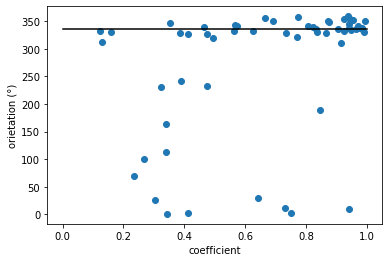

In [31]:
#plot
plt.scatter(orc1,or1)
#plt.savefig('./%s_or.png'%station)
plt.plot(np.arange(0,1.1,0.1),mean*np.ones(11),'black')
plt.ylabel("orietation (°)") 
plt.xlabel("coefficient")
plt.show()


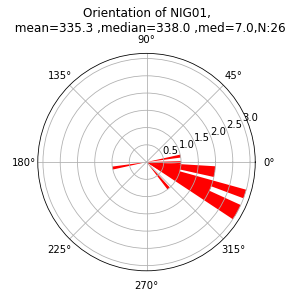

In [32]:
#calculate a reliable orientation
l=len(or1)
count=0
theta=[]

for i in range(0,l):
    if orc1[i]>0.8:
        theta.append(or1[i])
        count=count+1

mean=(np.mean((np.array(theta)+180)%360)+180)%360

median=(np.median((np.array(theta)+180)%360)+180)%360

med=np.median(abs(theta-median))


theta=np.unique(theta)
radii=np.zeros(len(theta))
for i in range(0,len(theta)):
    radii[i]=np.count_nonzero(or1==theta[i])
   

colors = plt.cm.viridis(radii )

ax = plt.subplot(projection='polar')
ax.bar(theta*np.pi/180, radii,width=5/180*np.pi, bottom=0.0, color='red')


ax.set_title("Orientation of %s,\n  mean=%0.1f ,median=%0.1f ,med=%0.1f,N:%d"%(station,mean,median,med,count), va='top')
plt.savefig('./%s_or_polar.png'%station)
plt.show()